In [1]:
import pandas as pd
import json
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [3]:
import json
import pandas as pd

# Load the JSON file
file_path = './downloaded_data.json'  # Replace with your file path
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert the "datetime" field to a DataFrame
df = pd.DataFrame({'datetime': data['datetime'], 'Hp60': data['Hp60']})

In [4]:
def change_time(df):
    # Remove the 'Z' and convert to Pandas datetime format
    df['datetime'] = pd.to_datetime(df['datetime'].str.replace('Z', ''))

    # Separate components
    df['date'] = df['datetime'].dt.date       # Extract date
    df['time'] = df['datetime'].dt.time       # Extract time
    df['year'] = df['datetime'].dt.year       # Extract year
    df['month'] = df['datetime'].dt.month     # Extract month
    df['day'] = df['datetime'].dt.day         # Extract day
    df['hour'] = df['datetime'].dt.hour       # Extract hour

    df = df.drop(columns=['datetime','date','time'])
    
    return df

df = change_time(df)

In [5]:
train_df = df[df['year']!=2024]
test_df = df[df['year']==2024]

# Dataloader

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [7]:
class Sliding_window(Dataset):
    def __init__(self, df, X_point, y_point):
        self.df = df
        self.X_point = X_point
        self.y_point = y_point
        self.sequence24 = []
        self.sequence6 = []
        
        counter = 1
        temp_x = []
        temp_y = []
        for idx,i in enumerate(self.df['Hp60']):
            if counter <= self.X_point:
                temp_x.append(i)
            else:
                temp_y.append(i)
            
            if (idx + 1) % (X_point + y_point) == 0:
                self.sequence24.append(temp_x)
                self.sequence6.append(temp_y)
                temp_x = []
                temp_y = []
                counter = 0
             
            counter += 1    
    
    def __len__(self):
        return len(self.sequence24)

    def __getitem__(self, idx):
        data = torch.Tensor(self.sequence24[idx])
        label = torch.Tensor(self.sequence6[idx])
        
        return data, label


In [8]:
train_dataset = Sliding_window(df=train_df,
                         X_point=24,
                         y_point=6)
test_dataset = Sliding_window(df=test_df,
                         X_point=24,
                         y_point=6)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
x,y = train_dataset[2:5]

In [11]:
x

tensor([[0.3330, 0.0000, 0.0000, 0.3330, 0.6670, 0.0000, 0.0000, 0.0000, 0.3330,
         0.3330, 0.6670, 0.6670, 1.3330, 0.0000, 0.0000, 0.0000, 0.0000, 0.3330,
         0.6670, 0.3330, 1.3330, 1.0000, 1.0000, 0.3330],
        [0.0000, 0.3330, 0.3330, 0.3330, 0.6670, 0.6670, 2.6670, 1.6670, 2.0000,
         1.0000, 1.3330, 1.0000, 1.3330, 1.6670, 1.0000, 0.0000, 0.6670, 1.3330,
         3.0000, 4.6670, 4.0000, 3.3330, 2.6670, 1.3330],
        [3.0000, 3.6670, 3.3330, 3.3330, 3.0000, 2.3330, 4.0000, 3.3330, 3.3330,
         2.3330, 2.6670, 3.0000, 2.3330, 2.0000, 2.3330, 1.3330, 2.0000, 2.0000,
         1.6670, 1.3330, 1.3330, 1.6670, 1.6670, 1.3330]])

In [12]:
y

tensor([[0.3330, 0.0000, 0.0000, 0.3330, 0.6670, 0.0000],
        [2.0000, 1.0000, 1.3330, 2.3330, 2.6670, 4.0000],
        [1.0000, 2.0000, 1.3330, 1.6670, 2.0000, 2.0000]])

# Model

In [13]:
class TransformerForecaster(nn.Module):
    def __init__(self, input_seq=24, output_seq=6, d_model=64, nhead=4, num_layers=3):
        super(TransformerForecaster, self).__init__()

        self.input_seq = input_seq
        self.output_seq = output_seq
        self.d_model = d_model

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fully connected layer for prediction
        self.fc = nn.Linear(d_model, output_seq)

        # Learnable positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(input_seq, d_model)) 

    def forward(self, x):
        x = x.unsqueeze(-1)  # Reshape (batch, seq) -> (batch, seq, 1)
        x = x.repeat(1, 1, self.d_model)  # Expand to match d_model size (batch, seq, d_model)

        # Add positional encoding
        pos_enc = self.positional_encoding.unsqueeze(0).expand(x.shape[0], -1, -1)  # (batch, seq, d_model)
        x = x + pos_enc  # Add position info

        x = x.permute(1, 0, 2)  # Change to (seq_len, batch, d_model) for Transformer

        x = self.transformer(x)  # Encode input sequence
        x = x[-1, :, :]  # Use last time step's feature vector
        x = self.fc(x)  # Output (batch, output_seq)

        return x

# Example Usage
batch_size = 32
input_seq = 24  # Input past 24 time steps
output_seq = 6  # Predict next 6 time steps

model = TransformerForecaster(input_seq=input_seq, output_seq=output_seq)

# Fake geomagnetic data: (batch, seq)
x = torch.randn(batch_size, input_seq)  # (32, 24)
y_pred = model(x)  # Predict next 6 steps
print(y_pred.shape)  # (32, 6)

torch.Size([32, 6])


/opt/anaconda3/envs/env_imageProcessing/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Train

In [14]:
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 20

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.
    
    train_dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, futures) in enumerate(train_dataloader):
        inputs, futures = inputs, futures
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, futures)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.4f}")
    running_loss = 0.0

Epoch 1/20: 100%|██████████| 28/28 [00:01<00:00, 16.76it/s]


Epoch: 1, Batch: 28, Loss: 0.4937


Epoch 2/20: 100%|██████████| 28/28 [00:01<00:00, 20.28it/s]


Epoch: 2, Batch: 28, Loss: 0.4614


Epoch 3/20: 100%|██████████| 28/28 [00:01<00:00, 20.51it/s]


Epoch: 3, Batch: 28, Loss: 0.4581


Epoch 4/20: 100%|██████████| 28/28 [00:01<00:00, 20.20it/s]


Epoch: 4, Batch: 28, Loss: 0.4524


Epoch 5/20: 100%|██████████| 28/28 [00:01<00:00, 19.74it/s]


Epoch: 5, Batch: 28, Loss: 0.4469


Epoch 6/20: 100%|██████████| 28/28 [00:01<00:00, 20.36it/s]


Epoch: 6, Batch: 28, Loss: 0.4556


Epoch 7/20: 100%|██████████| 28/28 [00:01<00:00, 20.63it/s]


Epoch: 7, Batch: 28, Loss: 0.4483


Epoch 8/20: 100%|██████████| 28/28 [00:01<00:00, 20.32it/s]


Epoch: 8, Batch: 28, Loss: 0.4573


Epoch 9/20: 100%|██████████| 28/28 [00:01<00:00, 20.03it/s]


Epoch: 9, Batch: 28, Loss: 0.4632


Epoch 10/20: 100%|██████████| 28/28 [00:01<00:00, 20.45it/s]


Epoch: 10, Batch: 28, Loss: 0.4604


Epoch 11/20: 100%|██████████| 28/28 [00:01<00:00, 20.57it/s]


Epoch: 11, Batch: 28, Loss: 0.4637


Epoch 12/20: 100%|██████████| 28/28 [00:01<00:00, 20.44it/s]


Epoch: 12, Batch: 28, Loss: 0.4706


Epoch 13/20: 100%|██████████| 28/28 [00:01<00:00, 20.07it/s]


Epoch: 13, Batch: 28, Loss: 0.4867


Epoch 14/20: 100%|██████████| 28/28 [00:01<00:00, 20.45it/s]


Epoch: 14, Batch: 28, Loss: 0.5037


Epoch 15/20: 100%|██████████| 28/28 [00:01<00:00, 20.67it/s]


Epoch: 15, Batch: 28, Loss: 0.5037


Epoch 16/20: 100%|██████████| 28/28 [00:01<00:00, 20.58it/s]


Epoch: 16, Batch: 28, Loss: 0.5065


Epoch 17/20: 100%|██████████| 28/28 [00:01<00:00, 20.04it/s]


Epoch: 17, Batch: 28, Loss: 0.5084


Epoch 18/20: 100%|██████████| 28/28 [00:01<00:00, 19.45it/s]


Epoch: 18, Batch: 28, Loss: 0.5114


Epoch 19/20: 100%|██████████| 28/28 [00:01<00:00, 20.36it/s]


Epoch: 19, Batch: 28, Loss: 0.5239


Epoch 20/20: 100%|██████████| 28/28 [00:01<00:00, 19.50it/s]

Epoch: 20, Batch: 28, Loss: 0.5140


# Test

In [15]:
model.eval()

total_loss = 0
total_samples = 0

all_predictions = []
all_ground_truths = [] 
# Wrap the test dataloader with tqdm
test_dataloader = tqdm(test_dataloader, desc="Evaluation")

with torch.no_grad():
    for inputs, futures in test_dataloader:
        inputs, futures = inputs, futures
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, futures)
        total_loss += loss.item() * inputs.size(0)  # Accumulate loss
        total_samples += inputs.size(0)
        
        all_predictions.append(outputs)
        all_ground_truths.append(futures)
        
avg_loss = total_loss / total_samples
print("avg_loss",avg_loss)
print("total_loss",total_loss)
print("total_samples",total_samples)

Evaluation: 100%|██████████| 9/9 [00:00<00:00, 97.98it/s]

avg_loss 2.1639053888488236
total_loss 616.7130358219147
total_samples 285


In [16]:
print("avg_loss",avg_loss)
print("total_loss",total_loss)
print("total_samples",total_samples)

avg_loss 2.1639053888488236
total_loss 616.7130358219147
total_samples 285


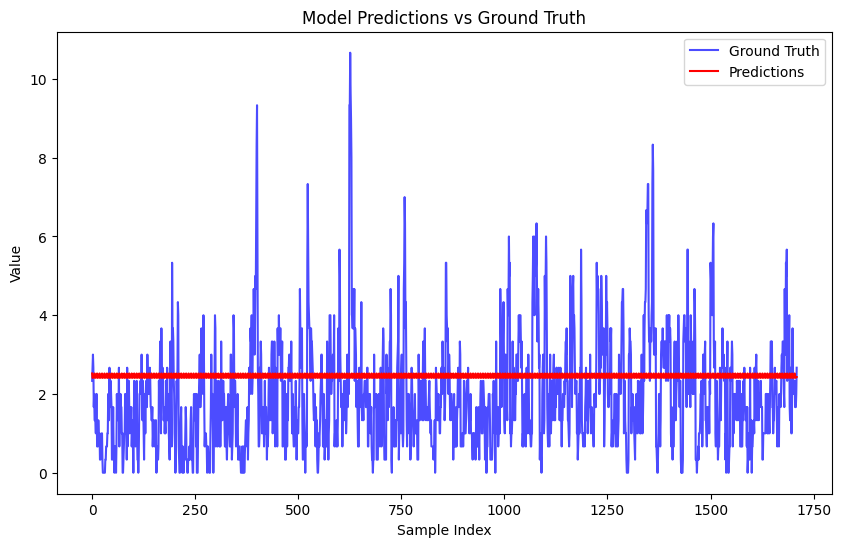

In [17]:
# Convert saved outputs and ground truths into tensors
all_predictions = torch.cat(all_predictions, dim=0)
all_ground_truths = torch.cat(all_ground_truths, dim=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(all_ground_truths.numpy().flatten(), label='Ground Truth', color='blue', alpha=0.7)
plt.plot(all_predictions.numpy().flatten(), label='Predictions', color='red', alpha=1)
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Model Predictions vs Ground Truth')
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(all_ground_truths, all_predictions)
mse = mean_squared_error(all_ground_truths, all_predictions) 

print('mae',mae)
print('mse',mse)

mae 1.1835653447616867
mse 2.163905403484931
